# MI2 - ES03: Batch preprocessing and Online PCA
## The chantastic 4: Elisabeth Kress, Paola Suárez, Jianmeng Wu and Esra Zihni

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
%matplotlib inline

## 1. Preprocessing

### 1. a) Load data and compute PCA

In [2]:
# 2d data
filename = "pca2.csv"
data = np.loadtxt(filename, delimiter=',', skiprows=1)

# Zero-mean
data -= data.mean(axis=0)

In [3]:
# PCA
cov = np.cov(data.T)
l, w = LA.eig(cov)

# Projection into PCs
PCs = np.dot(w.T, data.T)

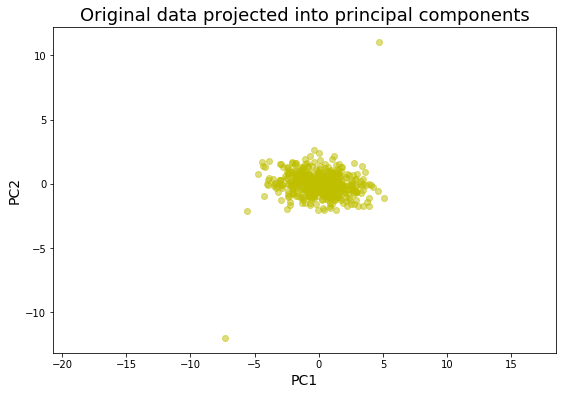

In [4]:
# Plot
plt.figure(figsize=(9,6))
plt.scatter(PCs[0,:], PCs[1,:], alpha=0.5, c='y')
plt.title("Original data projected into principal components", size=18)
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)
plt.axis('equal')
plt.show()

The reconstruction unveils two outliers, which contribute variance in a direction that is not aligned with the true dimensions of highest variance in the data. This means, the principal components are tilted accroding to the variance caused by the outliers. 

### 1. b) Remove outliers

In [5]:
# Remove 17 and 157, i.e. 16 and 156 in python indexing.
data_wo = np.delete(data, [16, 156], axis=0)

data_wo -= np.mean(data_wo, axis=0)

In [6]:
# PCA
cov_wo = np.cov(data_wo.T)
l_wo, w_wo = LA.eig(cov_wo)

# Projection onto PCs
PCs_wo = np.dot(w_wo.T, data_wo.T)

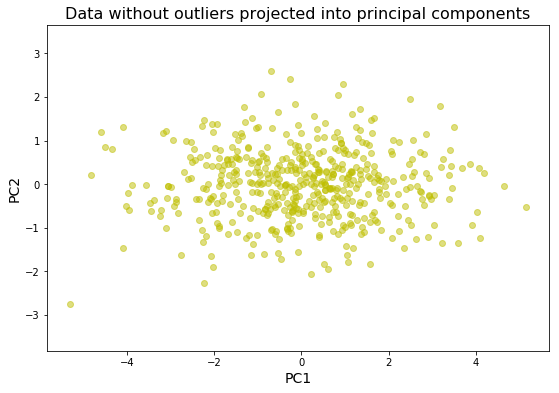

In [7]:
# Plot
plt.figure(figsize=(9,6))
plt.scatter(PCs_wo[0], PCs_wo[1], alpha=0.5, c='y')
plt.title("Data without outliers projected into principal components", size=16)
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)
plt.axis('equal')
plt.show()

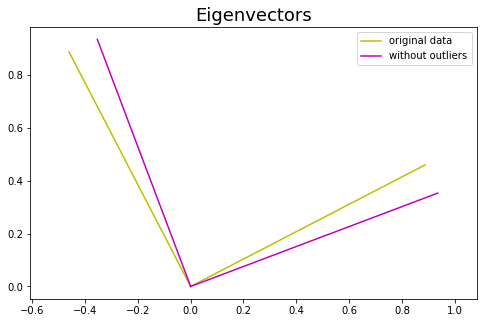

In [8]:
# plot eigenvectors
plt.figure(figsize=(8,5))
plt.plot([0, w[0,0]], [0, w[1,0]], 'y', label='original data')
plt.plot([0, w[0,1]], [0, w[1,1]], 'y')
plt.plot([0, w_wo[0,0]], [0, w_wo[1,0]], 'm', label='without outliers')
plt.plot([0, w_wo[0,1]], [0, w_wo[1,1]], 'm')
plt.title('Eigenvectors', size=18)
plt.axis('equal')
plt.legend()
plt.show()

The PCs of the data without outliers are tilted as compared to the PC of the original data containing outliers. As explained above, the outliers bias the PCs in the direction in which they lie.

## 2. Whitening

### 2. a) Load data set and check for outliers

In [9]:
# 4d data
filename = "pca4.csv"
data4 = np.loadtxt(filename, delimiter=',', skiprows=1)

# Zero mean
data4 -= np.mean(data4, axis=0)

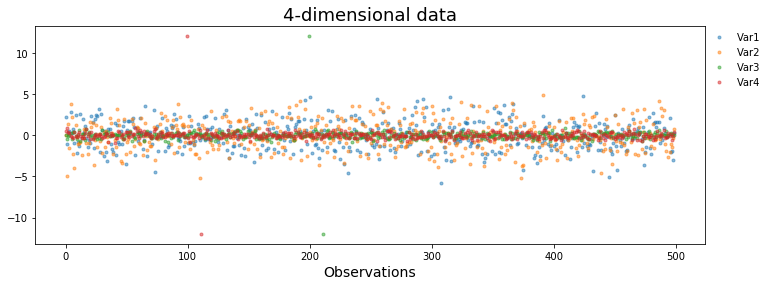

In [10]:
# Plot to check for outliers
plt.figure(figsize=(12,4))
for c in range(data4.shape[-1]):
    plt.plot(data4[:,c], '.', label="Var%i" %(c+1), alpha=.5)
plt.legend(loc=(1,0.7), frameon=False)
plt.title('4-dimensional data', size=18)
plt.xlabel('Observations', size=14)
plt.show()

We have four outliers; to have reasonable data for PCA we will remove them.

In [11]:
# Finda max and min, replace them with the mean
col2, col3 = data4.copy()[:,2:].T
max_idx = np.argmax([col2, col3], axis=1)
min_idx = np.argmin([col2, col3], axis=1)
col2 = np.delete(col2, [max_idx[0], min_idx[0]]) # [np.argmax(col2), np.argmin(col2)])
col3 = np.delete(col3, [max_idx[1], min_idx[1]])
mean2, mean3 = np.mean([col2, col3], axis=1)

data4_wo = data4.copy()
data4_wo[[max_idx[0], min_idx[0]], 2] = mean2
data4_wo[[max_idx[1], min_idx[1]], 3] = mean3

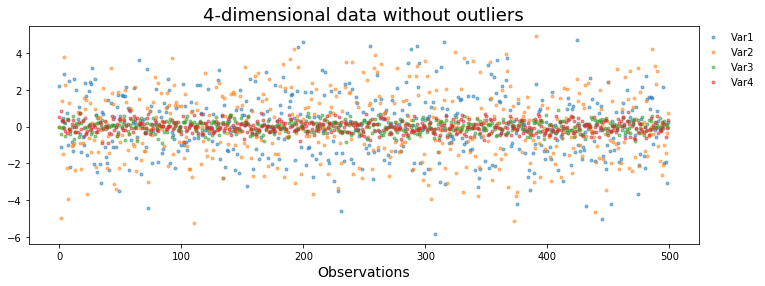

In [12]:
# Plot again to see the result
plt.figure(figsize=(12,4))
for c in range(data4_wo.shape[-1]):
    plt.plot(data4_wo[:,c], '.', label="Var%i" %(c+1), alpha=.5)
plt.legend(loc=(1,0.7), frameon=False)
plt.title('4-dimensional data without outliers', size=18)
plt.xlabel('Observations', size=14)
plt.show()

### 2. b) PCA algorithm

In [13]:
# PCA
data4_wo -= data4_wo.mean(axis=0)
cov_wo = np.cov(data4_wo.T)
l_wo, w_wo = LA.eig(cov_wo)
l_wo = np.real(l_wo)

# Projection onto PCs
PCs_wo = np.dot(w_wo.T, data4_wo.T)

# Normalize eigenvalues
l_wo_n = l_wo/l_wo.sum() #LA.norm(l_wo, ord=1) is equivalent

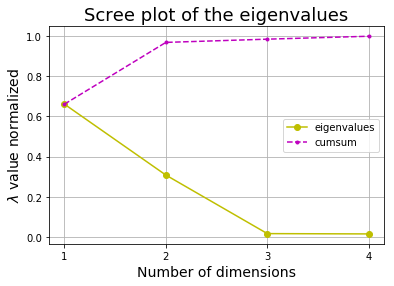

In [14]:
# Scree plot
plt.figure()
plt.plot([1,2,3,4], l_wo_n, 'yo-', label='eigenvalues')
plt.title("Scree plot of the eigenvalues", size=18)
plt.xlabel("Number of dimensions", size=14)
plt.ylabel(r"$\lambda$ value normalized", size=14)
plt.xticks([1,2,3,4])
plt.plot([1,2,3,4], np.cumsum(l_wo_n), 'm.--', label='cumsum')
plt.legend(loc=7)
plt.grid()
plt.show()

Three PCs are necessary to represent the data well.

### 2. c) Whiten the data

In [15]:
Z = np.dot(np.dot(data4_wo, w_wo), np.diag(l_wo**(-1/2))) # Don't use the normalized eigenvalues

### 2. d) Heat plots

In [16]:
# Covariance matrix of uncorrelated data
cov_Z = np.cov(Z.T)

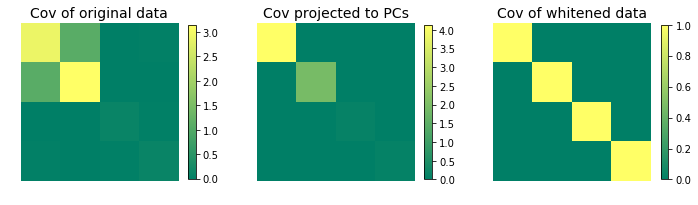

In [17]:
# Plot covariance matrices
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12,6))
im1 = ax1.imshow(cov_wo, cmap="summer")
ax1.set_title("Cov of original data", size=14)
ax1.axis("off")
im2 = ax2.imshow(np.cov(PCs_wo), cmap="summer")
ax2.set_title("Cov projected to PCs", size=14)
ax2.axis("off")
im3 = ax3.imshow(cov_Z, cmap="summer")
ax3.set_title("Cov of whitened data", size=14)
ax3.axis("off")
fig.colorbar(im1, ax=ax1, shrink=0.475)
fig.colorbar(im2, ax=ax2, shrink=0.475)
fig.colorbar(im3, ax=ax3, shrink=0.475)
plt.show()

The first heatmap shows that the first and the second variables are highly correlated. After projecting onto the PCs, all dimensions are decorrelated, but the diagonal has different values, i.e. the dimensions have different variance. Whitening the data normalizes the variances along all dimensions to 1. 

## 3. Oja's Rule: Derivation

In [18]:
# Load scan of derivation
filename = "ojas_derivation.jpg"
f = plt.imread(filename, format='jpg')

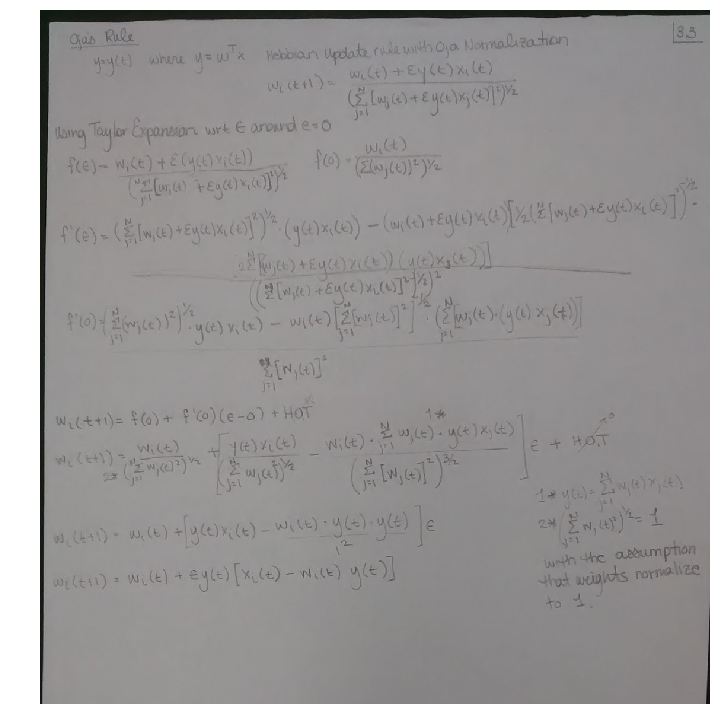

In [19]:
# Show analytical solution
plt.figure(figsize=(12,14))
plt.imshow(f[80:1250,20:,:])
plt.axis("off")
plt.show()

## 4. Oja's Rule: Application

In [20]:
# Load online data
data_oja = np.loadtxt('data-onlinePCA.txt', delimiter=',', skiprows=1, usecols=(1,2))

### 4. a) Oja's Rule Scatter Plot Temporal Evolution

In [21]:
batched_data = np.zeros((10,200,2))
for i, j in enumerate(np.arange(0,2000,200)):
       batched_data[i,:,:] = data_oja[j:j+200,:]

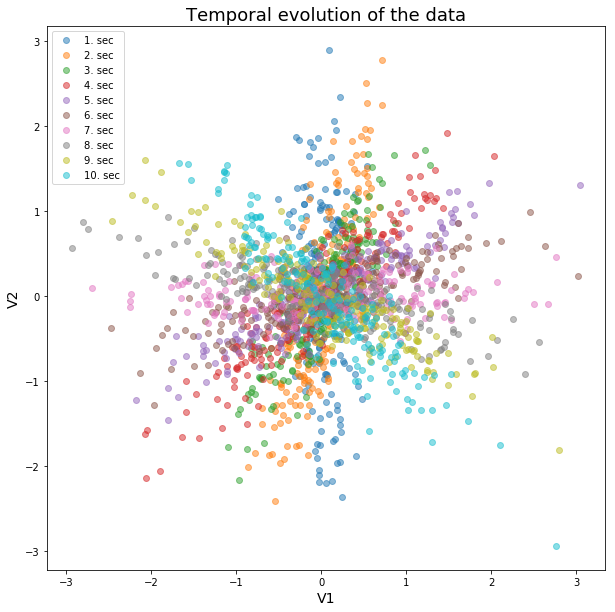

In [22]:
plt.figure(figsize=(10, 10))
for l in range(10):
    plt.plot(batched_data[l,:,0],batched_data[l,:,1],'o',alpha=0.5, label = '%i. sec' %(l+1))
plt.axis('equal')
plt.title("Temporal evolution of the data", fontsize=18)
plt.xlabel("V1", size=14)
plt.ylabel("V2", size=14)
plt.legend(loc='upper left')
plt.show()

### 4. b) Determining the PCA's

In [23]:
l_bd = np.zeros((10,2))
cov_bd = np.zeros((10,2,2))
w_bd = np.zeros((10,2,2))
pc1 = np.zeros((10,2))
for k in range(10):
    batched_data[k] -= np.mean(batched_data[k], axis=0)
    # PCA
    cov_bd[k] = np.cov(batched_data[k].T)
    l_bd[k], w_bd[k] = LA.eig(cov_bd[k])
    pc1[k]=w_bd[k,:,np.argmax(l_bd[k])]

/System/Library/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part


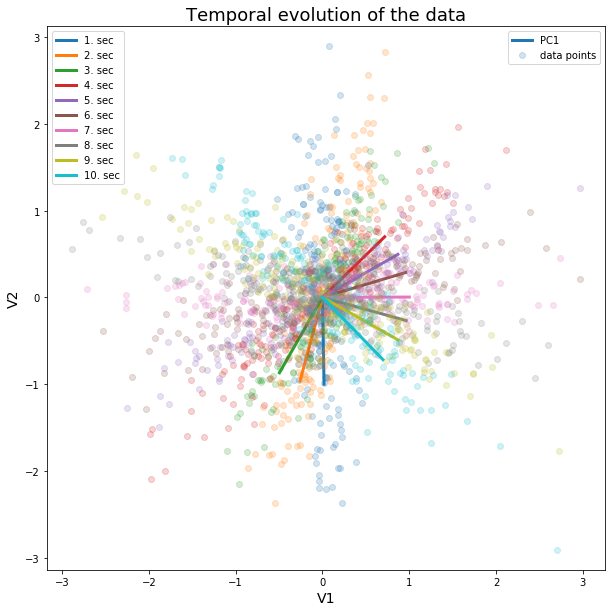

In [24]:
plt.figure(figsize=(10, 10))
plt.axis('equal')
plt.title("Temporal evolution of the data", fontsize=18)
plt.xlabel("V1", size=14)
plt.ylabel("V2", size=14)
plot_lines = []
ax = plt.gca()
for l in range(10):
    color = ax._get_lines.get_next_color()
    ln1, = plt.plot((0, pc1[l,0]),(0,pc1[l,1]),  linewidth=3.0, color=color)
    ln2, = plt.plot(batched_data[l,:,0],batched_data[l,:,1],'o', color=color,alpha=.2, label = '%i. sec' %(l+1))

    plot_lines.append([ln1, ln2])
        
legend1 = plt.legend(plot_lines[0], ['PC1', 'data points'], loc='upper right')
plt.legend([l[0] for l in plot_lines], ['%i. sec' %(l+1) for l in range(10)], loc='upper left')
plt.gca().add_artist(legend1)
plt.show()

### 4. c) Implement Oja's Rule

In [25]:
eps = [0.002, 0.04, 0.45]
def oja(eps):
    y = np.zeros((2000,1))
    weights = np.zeros((2001,2))
    weights[0] = np.random.rand(2)
    for i in range(data_oja.shape[0]):
        y[i] = np.dot(weights[i].T, data_oja[i])
        weights[i+1] = (weights[i] + eps*y[i]*data_oja[i])/LA.norm(weights[i] + eps*y[i]*data_oja[i])
    return weights

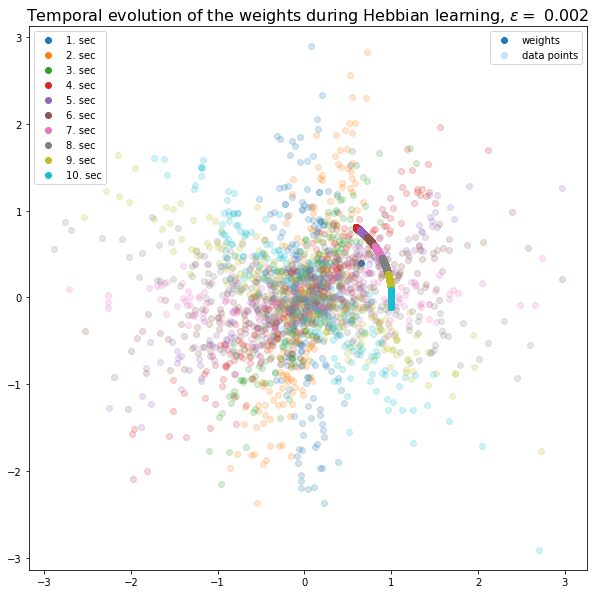

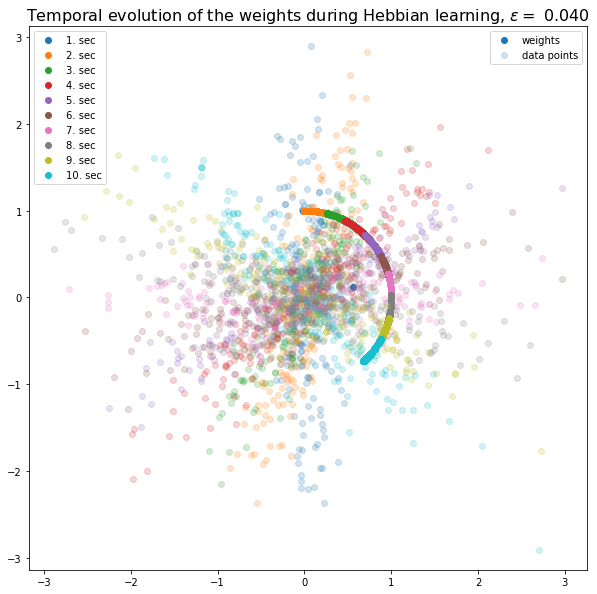

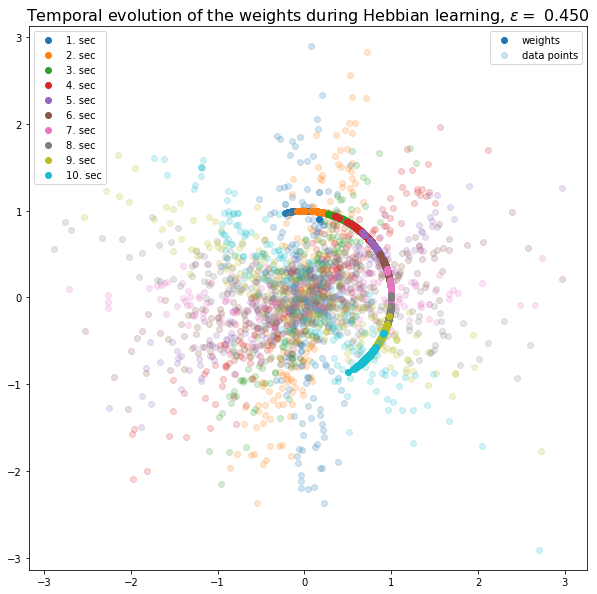

In [26]:
for i in eps:
    plt.figure(figsize = (10,10))
    plt.title(r'Temporal evolution of the weights during Hebbian learning, $\epsilon =\ %.03f$' %i, size=16)
    plt.axis('equal')
    plot_lines = []
    ax = plt.gca()
    
    weights = oja(i)
    batched_weights = np.zeros((10,200,2))
    for k, j in enumerate(np.arange(0,2000,200)):
        batched_weights[k,:,:] = weights[j:j+200,:]
    
    for l in range(10):
        color = ax._get_lines.get_next_color()
        ln1, = plt.plot(batched_weights[l,:,0],batched_weights[l,:,1], 'o', color=color, linewidth = 3.0)
        ln2, = plt.plot(batched_data[l,:,0],batched_data[l,:,1],'o', color=color,alpha=.2, label = '%i. sec' %(l+1))
        plot_lines.append([ln1, ln2])
    plt.legend(bbox_to_anchor=(1.05, 1))
    legend1 = plt.legend(plot_lines[0], ['weights', 'data points'], loc='upper right')
    plt.legend([l[0] for l in plot_lines], ['%i. sec' %(l+1) for l in range(10)], loc='upper left')
    plt.gca().add_artist(legend1)
    plt.show()

If the learning rate is too small, the weights are updated at small steps that are too slow for the temporal resolution of the data. The top figure shows that the color (which indicated time) of the weights are not aligned with the colors of the data points. The middle and the lower figures show alignment of the colors, i.e. the learning steps are well chosen.